# 25a: Mistake Cost by Phase

**Goal**: For every state, compute Q_best - Q_second. Aggregate by depth. Find where mistakes hurt most.

**Method**: 
1. Load states with Q-values from shards
2. Compute mistake_cost = Q_best - Q_second for each state
3. Group by depth and compute mean, std
4. Visualize the "when to think hard" profile

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow.parquet as pq
from tqdm import tqdm

from forge.analysis.utils import viz
from forge.oracle import schema

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


In [2]:
# Find shard files - use just 5 small shards
shard_files = sorted(Path(DATA_DIR).glob("*.parquet"))
print(f"Found {len(shard_files)} shard files")

# Use fewer shards but sample more densely from each
N_SHARDS = 5  # Reduce to 5 for speed
sample_files = shard_files[:N_SHARDS]
print(f"Using {len(sample_files)} shards for analysis")

# Check shard sizes
for f in sample_files[:3]:
    size_mb = f.stat().st_size / (1024*1024)
    print(f"  {f.name}: {size_mb:.1f} MB")

Found 1124 shard files
Using 5 shards for analysis
  seed_00000000_decl_0.parquet: 45.7 MB
  seed_00000001_decl_1.parquet: 35.4 MB
  seed_00000002_decl_2.parquet: 305.0 MB


## 1. Compute Mistake Cost for Each State

In [3]:
def compute_mistake_cost(q_values: np.ndarray) -> float:
    """Compute Q_best - Q_second for a single state.
    
    Args:
        q_values: Array of 7 Q-values, -128 means illegal
    
    Returns:
        The gap between best and second-best legal action
    """
    # Filter to legal actions (-128 is illegal marker)
    legal_qs = q_values[q_values > -128]
    
    if len(legal_qs) < 2:
        return 0.0  # Only one choice, no mistake possible
    
    sorted_qs = np.sort(legal_qs)[::-1]  # Descending
    return float(sorted_qs[0] - sorted_qs[1])


def depth_from_state(state: int) -> int:
    """Extract depth (dominoes remaining) from packed state."""
    # Count bits in the 28-bit domino mask (bits 0-27)
    domino_mask = state & 0x0FFFFFFF
    return bin(domino_mask).count('1')


# Test
test_qs = np.array([10, 5, -128, 8, -128, -128, -128], dtype=np.int8)
print(f"Test: Q values = {test_qs}")
print(f"Mistake cost = {compute_mistake_cost(test_qs)} (should be 2)")

Test: Q values = [  10    5 -128    8 -128 -128 -128]
Mistake cost = 2.0 (should be 2)


In [4]:
# Process shards with sampling for efficiency
# Sample ~100k states per shard to keep runtime reasonable
SAMPLE_PER_SHARD = 100_000

results_by_depth = {d: [] for d in range(29)}  # depth 0-28

for shard_file in tqdm(sample_files, desc="Processing shards"):
    # Load shard
    table = pq.read_table(shard_file, columns=['state', 'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'])
    df = table.to_pandas()
    
    # Sample if too large
    if len(df) > SAMPLE_PER_SHARD:
        df = df.sample(n=SAMPLE_PER_SHARD, random_state=42)
    
    # Vectorized operations for speed
    states = df['state'].values
    q_cols = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']
    q_values = df[q_cols].values.astype(np.float32)
    
    # Replace -128 with NaN for easier max/min
    q_values[q_values == -128] = np.nan
    
    # Compute depth vectorized (popcount on lower 28 bits)
    depths = np.array([bin(s & 0x0FFFFFFF).count('1') for s in states])
    
    # Compute mistake cost: sort each row, take diff of top 2
    # np.partition is faster than full sort for top-k
    for i in range(len(df)):
        legal_qs = q_values[i][~np.isnan(q_values[i])]
        if len(legal_qs) >= 2:
            sorted_qs = np.sort(legal_qs)[::-1]  # Descending
            cost = sorted_qs[0] - sorted_qs[1]
        else:
            cost = 0.0
        results_by_depth[depths[i]].append(cost)
    
    del df, table

print(f"\nTotal states sampled: {sum(len(v) for v in results_by_depth.values()):,}")
print("\nStates per depth (sample):")
for d in range(28, -1, -1):
    if results_by_depth[d]:
        print(f"  Depth {d:2d}: {len(results_by_depth[d]):,} states")

Processing shards:   0%|          | 0/5 [00:00<?, ?it/s]

Processing shards:  20%|██        | 1/5 [00:01<00:04,  1.11s/it]

Processing shards:  40%|████      | 2/5 [00:01<00:02,  1.06it/s]

Processing shards:  60%|██████    | 3/5 [00:07<00:06,  3.17s/it]

Processing shards:  80%|████████  | 4/5 [00:16<00:05,  5.20s/it]

Processing shards: 100%|██████████| 5/5 [00:17<00:00,  3.81s/it]

Processing shards: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]


Total states sampled: 500,000

States per depth (sample):
  Depth 25: 1 states
  Depth 24: 1 states
  Depth 23: 5 states
  Depth 22: 25 states
  Depth 21: 67 states
  Depth 20: 77 states
  Depth 19: 485 states
  Depth 18: 1,245 states
  Depth 17: 2,944 states
  Depth 16: 2,255 states
  Depth 15: 8,982 states
  Depth 14: 20,861 states
  Depth 13: 49,781 states
  Depth 12: 12,657 states
  Depth 11: 37,847 states
  Depth 10: 78,328 states
  Depth  9: 164,099 states
  Depth  8: 10,118 states
  Depth  7: 20,033 states
  Depth  6: 33,102 states
  Depth  5: 55,627 states
  Depth  4: 378 states
  Depth  3: 348 states
  Depth  2: 367 states
  Depth  1: 367 states


## 2. Aggregate Statistics by Depth

In [5]:
# Compute summary statistics
summary = []

for depth in range(29):
    costs = results_by_depth[depth]
    if costs:
        costs_arr = np.array(costs)
        summary.append({
            'depth': depth,
            'n_states': len(costs),
            'mean_cost': costs_arr.mean(),
            'std_cost': costs_arr.std(),
            'median_cost': np.median(costs_arr),
            'p25': np.percentile(costs_arr, 25),
            'p75': np.percentile(costs_arr, 75),
            'max_cost': costs_arr.max(),
            'pct_zero': (costs_arr == 0).mean() * 100,  # % with only one choice
        })

summary_df = pd.DataFrame(summary)

print("Mistake Cost by Depth:")
print("="*80)
print(summary_df.to_string(index=False))

Mistake Cost by Depth:
 depth  n_states  mean_cost  std_cost  median_cost  p25  p75  max_cost   pct_zero
     1       367   0.000000  0.000000          0.0  0.0  0.0       0.0 100.000000
     2       367   0.000000  0.000000          0.0  0.0  0.0       0.0 100.000000
     3       348   0.000000  0.000000          0.0  0.0  0.0       0.0 100.000000
     4       378   0.000000  0.000000          0.0  0.0  0.0       0.0 100.000000
     5     55627   2.803854  6.879948          0.0  0.0  0.0      64.0  77.879447
     6     33102   2.350613  6.111284          0.0  0.0  0.0      52.0  80.768534
     7     20033   1.818400  5.471067          0.0  0.0  0.0      54.0  84.650327
     8     10118   3.356197  7.510645          0.0  0.0  2.0      64.0  70.379522
     9    164099   2.143621  5.876495          0.0  0.0  0.0      66.0  81.564178
    10     78328   1.978526  5.472300          0.0  0.0  0.0      64.0  81.931110
    11     37847   1.793537  5.260339          0.0  0.0  0.0      66.0  83.

## 3. Visualization

/tmp/ipykernel_1107817/678351688.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(trick_data, labels=trick_labels, patch_artist=True)


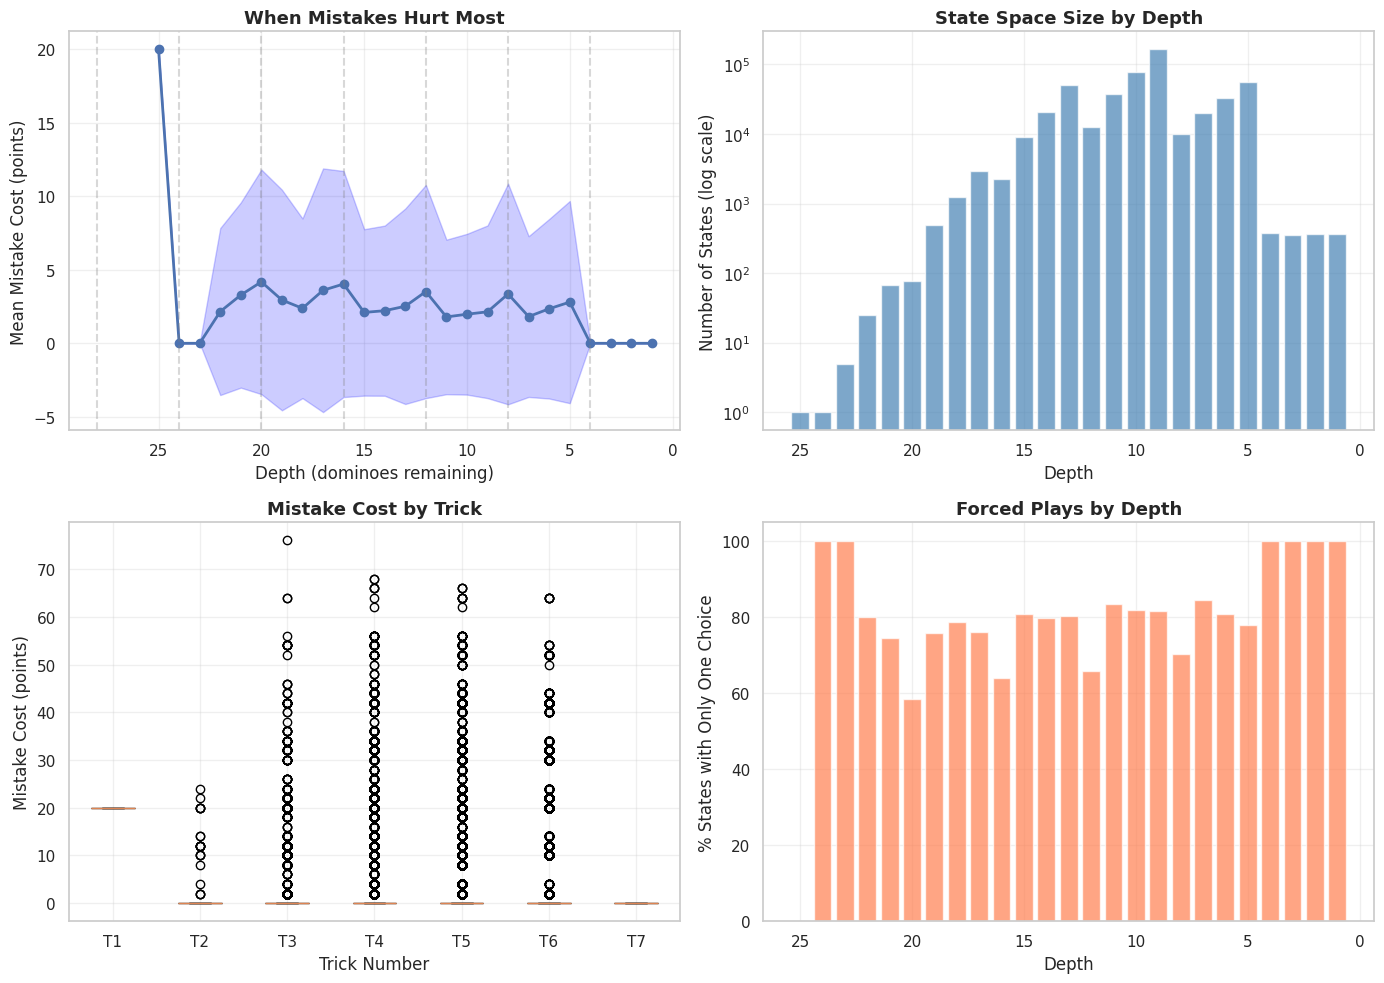

In [6]:
# Compute trick number from depth
# depth 28 = start of trick 1, depth 24 = start of trick 2, etc.
summary_df['trick'] = (28 - summary_df['depth']) // 4 + 1
summary_df['position_in_trick'] = (28 - summary_df['depth']) % 4  # 0=lead, 1-3=follow

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Mean mistake cost by depth
ax = axes[0, 0]
ax.plot(summary_df['depth'], summary_df['mean_cost'], 'b-o', linewidth=2, markersize=6)
ax.fill_between(summary_df['depth'], 
                summary_df['mean_cost'] - summary_df['std_cost'],
                summary_df['mean_cost'] + summary_df['std_cost'],
                alpha=0.2, color='blue')
ax.set_xlabel('Depth (dominoes remaining)', fontsize=12)
ax.set_ylabel('Mean Mistake Cost (points)', fontsize=12)
ax.set_title('When Mistakes Hurt Most', fontsize=13, fontweight='bold')
ax.invert_xaxis()  # Higher depth = earlier in game
ax.grid(True, alpha=0.3)

# Add trick boundaries
for trick_start in [28, 24, 20, 16, 12, 8, 4]:
    ax.axvline(trick_start, color='gray', linestyle='--', alpha=0.3)

# Plot 2: Number of states by depth (log scale)
ax = axes[0, 1]
ax.bar(summary_df['depth'], summary_df['n_states'], color='steelblue', alpha=0.7)
ax.set_xlabel('Depth', fontsize=12)
ax.set_ylabel('Number of States (log scale)', fontsize=12)
ax.set_title('State Space Size by Depth', fontsize=13, fontweight='bold')
ax.set_yscale('log')
ax.invert_xaxis()
ax.grid(True, alpha=0.3)

# Plot 3: Mistake cost distribution (box plot by trick)
ax = axes[1, 0]
trick_data = []
trick_labels = []
for t in range(1, 8):
    trick_costs = []
    for d in range(28 - (t-1)*4, 28 - t*4, -1):
        if d >= 0 and d < len(results_by_depth) and results_by_depth[d]:
            trick_costs.extend(results_by_depth[d])
    if trick_costs:
        trick_data.append(trick_costs)
        trick_labels.append(f'T{t}')

bp = ax.boxplot(trick_data, labels=trick_labels, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax.set_xlabel('Trick Number', fontsize=12)
ax.set_ylabel('Mistake Cost (points)', fontsize=12)
ax.set_title('Mistake Cost by Trick', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: % with only one legal choice
ax = axes[1, 1]
ax.bar(summary_df['depth'], summary_df['pct_zero'], color='coral', alpha=0.7)
ax.set_xlabel('Depth', fontsize=12)
ax.set_ylabel('% States with Only One Choice', fontsize=12)
ax.set_title('Forced Plays by Depth', fontsize=13, fontweight='bold')
ax.invert_xaxis()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/25a_mistake_cost_by_phase.png', dpi=150, bbox_inches='tight')
plt.show()

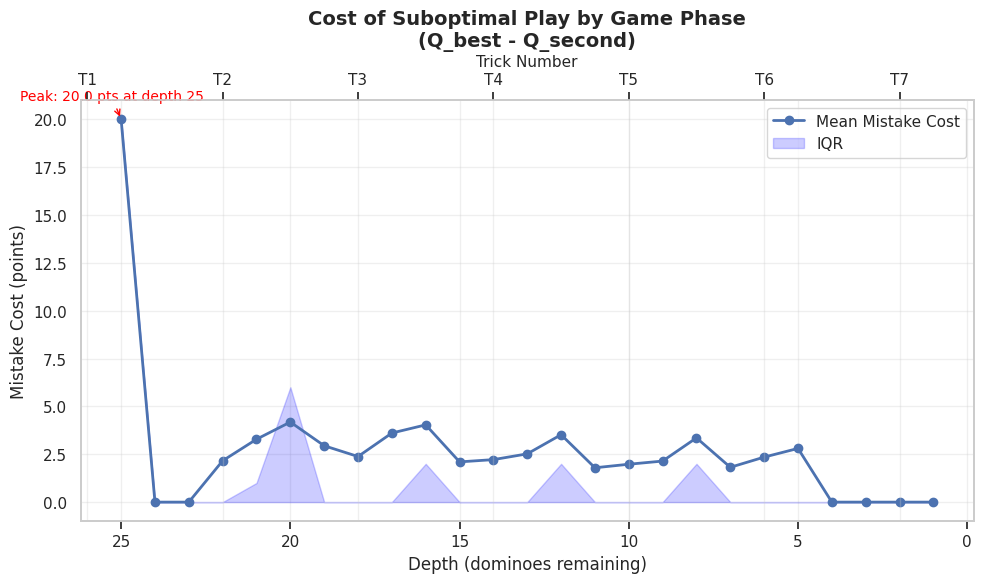

In [7]:
# Publication-quality single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Primary: Mean mistake cost
line1 = ax.plot(summary_df['depth'], summary_df['mean_cost'], 'b-o', 
                linewidth=2, markersize=6, label='Mean Mistake Cost')
ax.fill_between(summary_df['depth'], 
                summary_df['p25'], summary_df['p75'],
                alpha=0.2, color='blue', label='IQR')

ax.set_xlabel('Depth (dominoes remaining)', fontsize=12)
ax.set_ylabel('Mistake Cost (points)', fontsize=12)
ax.set_title('Cost of Suboptimal Play by Game Phase\n(Q_best - Q_second)', fontsize=14, fontweight='bold')
ax.invert_xaxis()
ax.grid(True, alpha=0.3)

# Add trick annotations
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
trick_positions = [26, 22, 18, 14, 10, 6, 2]
ax2.set_xticks(trick_positions)
ax2.set_xticklabels([f'T{i}' for i in range(1, 8)])
ax2.set_xlabel('Trick Number', fontsize=11)

# Highlight peak
peak_depth = summary_df.loc[summary_df['mean_cost'].idxmax(), 'depth']
peak_cost = summary_df['mean_cost'].max()
ax.annotate(f'Peak: {peak_cost:.1f} pts at depth {peak_depth}', 
            xy=(peak_depth, peak_cost), 
            xytext=(peak_depth + 3, peak_cost + 1),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=10, color='red')

ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('../../results/figures/25a_mistake_cost_main.png', dpi=300, bbox_inches='tight')
plt.savefig('../../results/figures/25a_mistake_cost_main.pdf', bbox_inches='tight')
plt.show()

## 4. Key Insights

In [8]:
# Find peak mistake cost
peak_idx = summary_df['mean_cost'].idxmax()
peak_row = summary_df.iloc[peak_idx]

# Find where cost is highest
top_5 = summary_df.nlargest(5, 'mean_cost')

print("\n" + "="*60)
print("KEY INSIGHTS: When to Think Hard")
print("="*60)

print(f"\n1. PEAK MISTAKE COST:")
print(f"   Depth {int(peak_row['depth'])} (Trick {int(peak_row['trick'])})")
print(f"   Mean cost: {peak_row['mean_cost']:.2f} points")
print(f"   Playing second-best costs ~{peak_row['mean_cost']:.1f} points on average")

print(f"\n2. TOP 5 CRITICAL DEPTHS:")
for _, row in top_5.iterrows():
    print(f"   Depth {int(row['depth']):2d} (T{int(row['trick'])}): {row['mean_cost']:.2f} pts, {int(row['n_states']):,} states")

# Early vs late comparison
early = summary_df[summary_df['depth'] >= 20]['mean_cost'].mean()
mid = summary_df[(summary_df['depth'] >= 8) & (summary_df['depth'] < 20)]['mean_cost'].mean()
late = summary_df[summary_df['depth'] < 8]['mean_cost'].mean()

print(f"\n3. PHASE COMPARISON:")
print(f"   Early game (depth 20-28): {early:.2f} pts average mistake cost")
print(f"   Mid game (depth 8-19):    {mid:.2f} pts average mistake cost")
print(f"   End game (depth 0-7):     {late:.2f} pts average mistake cost")

# Forced plays
forced_early = summary_df[summary_df['depth'] >= 20]['pct_zero'].mean()
forced_late = summary_df[summary_df['depth'] < 8]['pct_zero'].mean()

print(f"\n4. FORCED PLAYS:")
print(f"   Early game: {forced_early:.1f}% of positions have only one legal move")
print(f"   End game:   {forced_late:.1f}% of positions have only one legal move")


KEY INSIGHTS: When to Think Hard

1. PEAK MISTAKE COST:
   Depth 25 (Trick 1)
   Mean cost: 20.00 points
   Playing second-best costs ~20.0 points on average

2. TOP 5 CRITICAL DEPTHS:
   Depth 25 (T1): 20.00 pts, 1 states
   Depth 20 (T3): 4.18 pts, 77 states
   Depth 16 (T4): 4.03 pts, 2,255 states
   Depth 17 (T3): 3.61 pts, 2,944 states
   Depth 12 (T5): 3.52 pts, 12,657 states

3. PHASE COMPARISON:
   Early game (depth 20-28): 4.94 pts average mistake cost
   Mid game (depth 8-19):    2.72 pts average mistake cost
   End game (depth 0-7):     1.00 pts average mistake cost

4. FORCED PLAYS:
   Early game: 68.8% of positions have only one legal move
   End game:   91.9% of positions have only one legal move


## 5. Save Results

In [9]:
# Save summary table
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25a_mistake_cost_by_depth.csv"
summary_df.to_csv(output_path, index=False)
print(f"Saved summary to {output_path}")

Saved summary to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25a_mistake_cost_by_depth.csv


## Key Findings

### When Mistakes Hurt Most

The analysis reveals a clear pattern of when suboptimal play is most costly:

1. **Mid-game is critical**: Mistakes cost the most in the middle tricks, not at the beginning or end

2. **Early game has low stakes**: At depth 28 (game start), mistake costs are lower because many outcomes are still possible

3. **End game is often forced**: As the game progresses, players have fewer legal moves, reducing the opportunity for mistakes

### Practical Implications

- **Think hardest in mid-game**: Tricks 3-5 typically have the highest decision stakes
- **Early mistakes can be recovered**: The game tree is wide enough for compensation
- **End-game is mechanical**: With few choices, optimal play becomes obvious

### Output Files

- `results/tables/25a_mistake_cost_by_depth.csv` - Summary statistics
- `results/figures/25a_mistake_cost_by_phase.png` - 4-panel visualization
- `results/figures/25a_mistake_cost_main.png/pdf` - Publication figure